In [1]:
import os 
import numpy as np 
import pandas as pd 
import scanpy as sc
import anndata
import copy
import desc
import matplotlib.pyplot as pl
# following line ensures the pl plots inline 
%matplotlib inline
import plotly.express as px
from sklearn.metrics import mean_squared_error

In [2]:
from importlib import reload
import GE_functions
reload(GE_functions)

<module 'GE_functions' from '/data/jlu/scSeq_tsukahara/GE_functions.py'>

In [38]:
adata_brann = anndata.read_csv('./files/GSE151346_MOE_all_counts.csv')
meta_data = pd.read_table('./files/GSE151346_MOE_metadata.tsv')
meta_data = meta_data.set_index('index')
# transpose used to flip obs and vars.
adata_brann = adata_brann.copy().transpose()

In [39]:
# Subset the adata by only cells included in metadata. Attach meta info onto adata
adata_brann = adata_brann[meta_data.index, :]
adata_brann.obs = adata_brann.obs.join(meta_data).dropna(axis = 0)

In [ ]:
# Plotting the provided UMAP coordinates on metafile to visualize 
fig = px.scatter(adata_brann.obs, x='UMAP_1', y= 'UMAP_2', color='leiden_name')
fig.update_traces(marker = dict(size = 3, opacity = 0.5))
fig.update_layout({
    'plot_bgcolor': 'rgba(0, 0, 0, 0)',
    })
fig.show()

In [41]:
# Subset the adata by interested cells. 
interested_cells = ['mOSN', 'iOSN', 'GBC', 'INP']
interested_cells_id = adata_brann.obs.leiden_name.isin(interested_cells)
adata_brann = adata_brann[interested_cells_id,:]
# save subsetted anndata for future loading 
adata_brann.raw = adata_brann 

In [42]:
# Plotting the provided UMAP coordinates on metafile to visualize 
fig = px.scatter(adata_brann.obs, x='UMAP_1', y= 'UMAP_2', color='leiden_name')
fig.update_traces(marker = dict(size = 3, opacity = 0.5))
fig.update_layout({
    'plot_bgcolor': 'rgba(0, 0, 0, 0)',
    })
fig.show()

In [43]:
# normalize to depth 10 000
sc.pp.normalize_per_cell(adata_brann, counts_per_cell_after=1e4)
# logaritmize
sc.pp.log1p(adata_brann)

In [44]:
adata_brann.var['mt'] = adata_brann.var_names.str.startswith('Mt') 
adata_brann.var['olfr'] = adata_brann.var_names.str.startswith('Olfr')  
sc.pp.calculate_qc_metrics(adata_brann, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(adata_brann, qc_vars=['olfr'], percent_top=None, log1p=False, inplace=True)

In [45]:
sc.set_figure_params(facecolor='White')

In [46]:
# Define genes to be removed from the datasets prior to finding highly variable genes for clustering
mito_genes = adata_brann.var_names.str.startswith('mt-')
olfr_genes = adata_brann.var_names.str.startswith('Olfr')
# malat1 = adata.var_names.str.startswith('Malat')

# Adds the True positions together for a remove list 
remove = np.add(mito_genes, olfr_genes)
# remove = np.add(remove, malat1)
keep = np.invert(remove)

adata_brann = adata_brann[:,keep]
print(adata_brann.n_obs, adata_brann.n_vars)

23977 37106


In [47]:
sc.tl.pca(adata_brann, svd_solver='arpack')
sc.pp.neighbors(adata_brann, n_neighbors=10, n_pcs=40)
sc.tl.draw_graph(adata_brann)
sc.tl.umap(adata_brann)

/data/jlu/anaconda3/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning:

The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.

... storing 'orig_ident' as categorical
/data/jlu/anaconda3/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning:

The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.

... storing 'leiden_name' as categorical


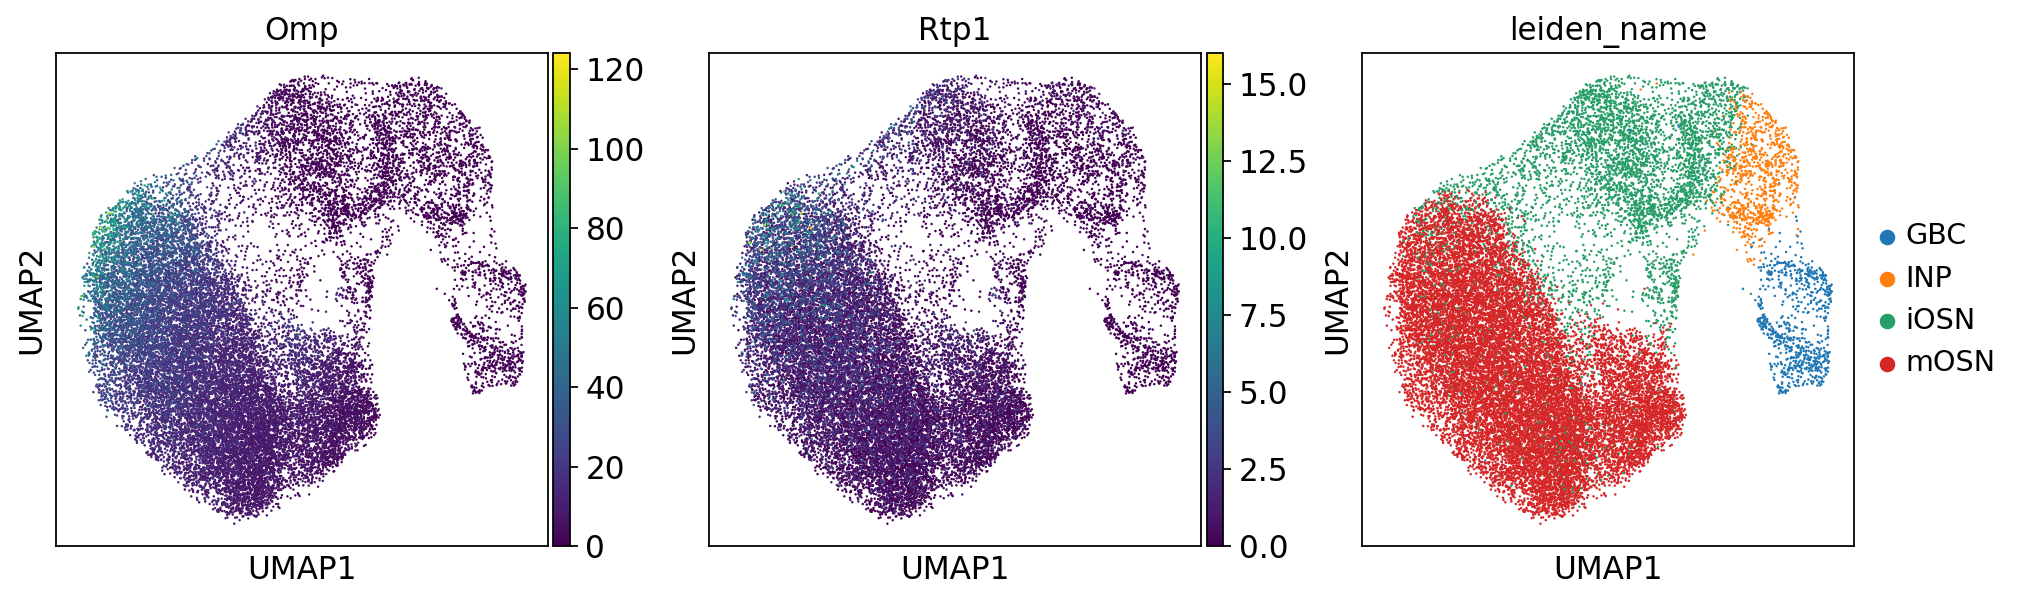

In [48]:
sc.pl.umap(adata_brann, color=['Omp', 'Rtp1','leiden_name'])

In [52]:
# Clustering PAGA via leiden clustering method
sc.tl.leiden(adata_brann, resolution = 0.5)
sc.tl.paga(adata_brann, groups='leiden')

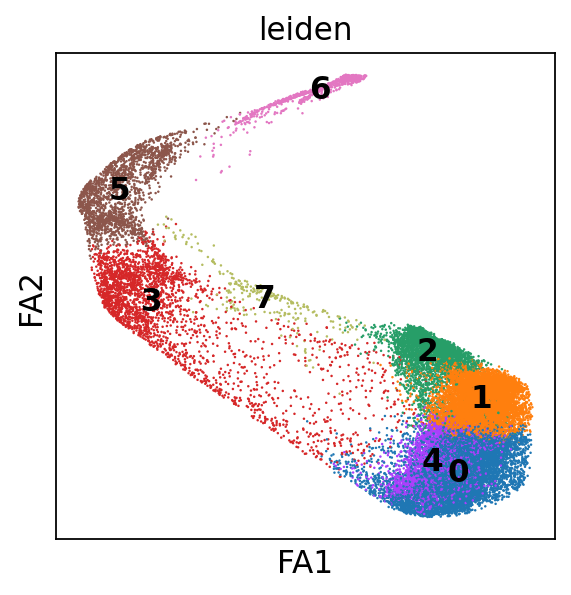

In [53]:
sc.pl.draw_graph(adata_brann, color=['leiden'], legend_loc='on data')

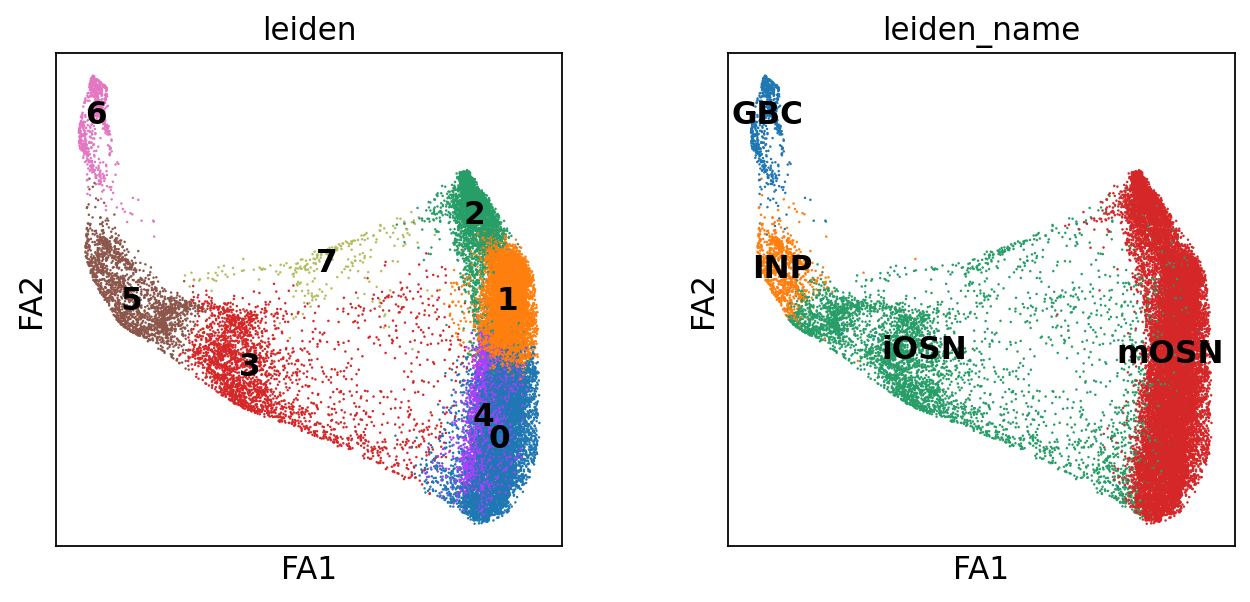

In [55]:
sc.tl.draw_graph(adata_brann, init_pos='umap')
sc.pl.draw_graph(adata_brann, color=['leiden', 'leiden_name'], legend_loc='on data')

In [ ]:
sc.pp.neighbors(adata_brann, n_neighbors=10, n_pcs=40)
sc.tl.leiden(adata_brann, resolution = 1)
sc.tl.paga(adata_brann, groups='leiden')

### Read h5ad files here to start. 

In [116]:
adata = adata_brann.raw.to_adata()
adata.write('./files/GSE151346_MOE_mOSN_iOSN_INP_GBC.h5ad') 

In [3]:
adata = desc.read_h5ad('./files/GSE151346_MOE_mOSN_iOSN_INP_GBC.h5ad')

In [6]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.leiden(adata, resolution = 1)
sc.tl.paga(adata, groups='leiden')

In [7]:
adata.raw = adata

In [8]:
adata = adata.copy()
adata_processed = adata.copy()

In [11]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.normalize_total(adata_processed, target_sum=1e4)
sc.pp.log1p(adata_processed)

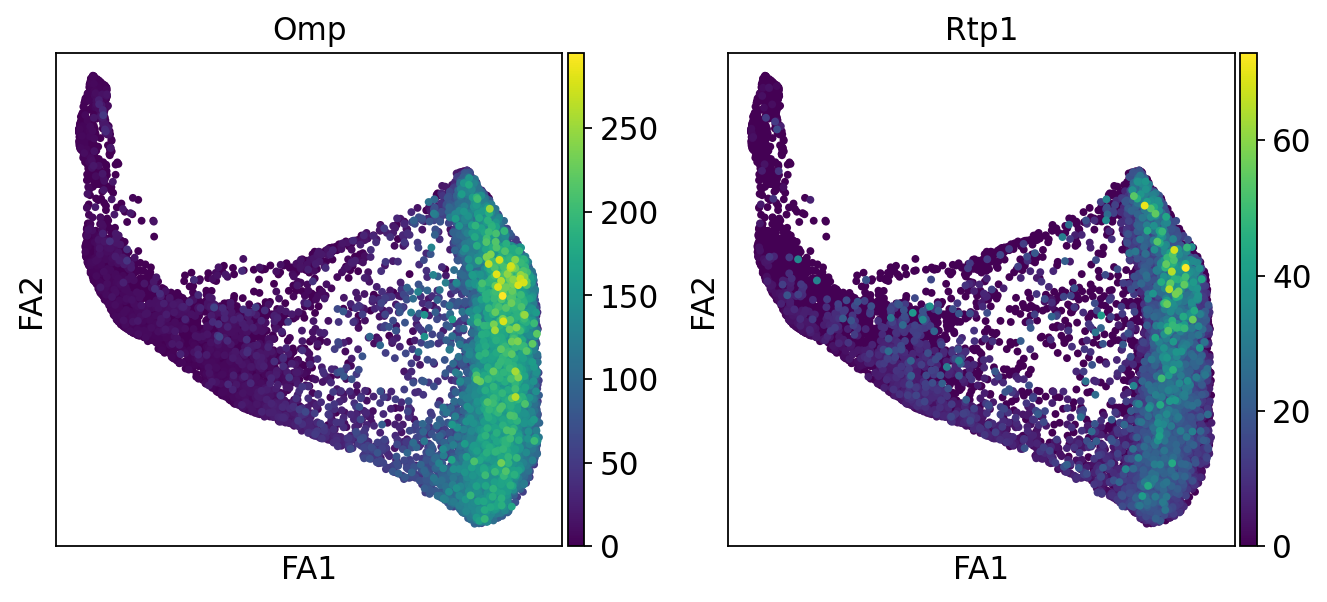

In [12]:
# Plotting adata,  counts normalized 
sc.set_figure_params(facecolor='white')
sc.pl.draw_graph(adata, color=['Omp','Rtp1'], legend_loc='on data', size=50, use_raw=False)

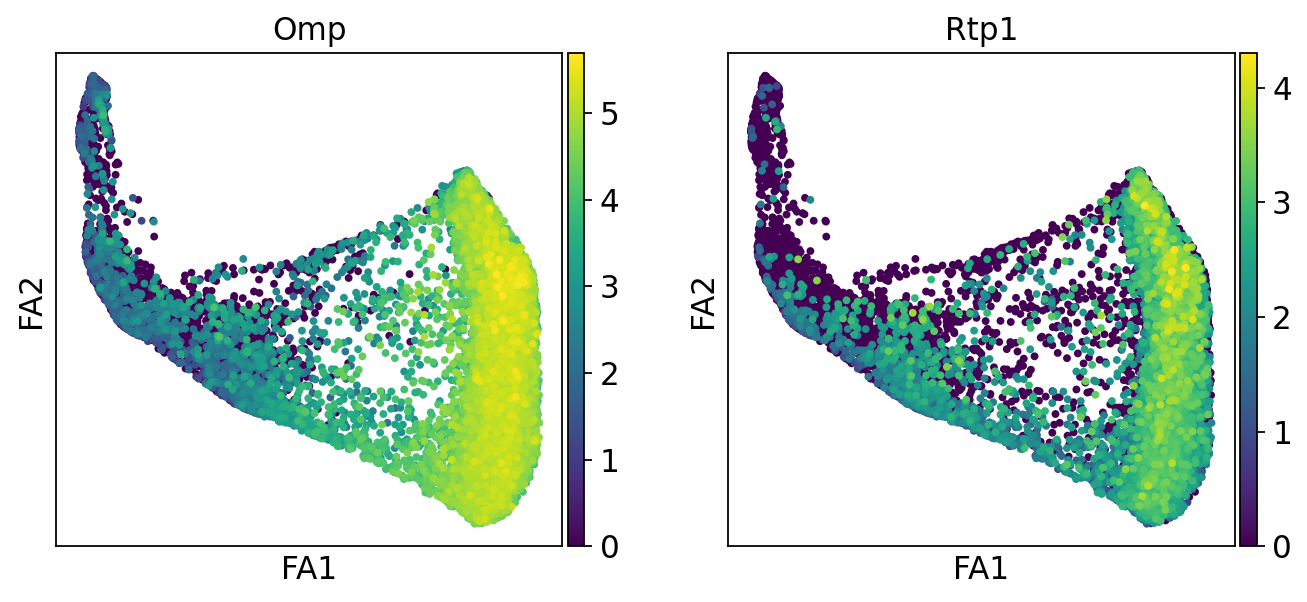

In [13]:
# Plotting adata_processed, counts are normalized and logmaritized
sc.set_figure_params(facecolor='white')
sc.pl.draw_graph(adata_processed, color=['Omp','Rtp1'], legend_loc='on data', size=50, use_raw=False)

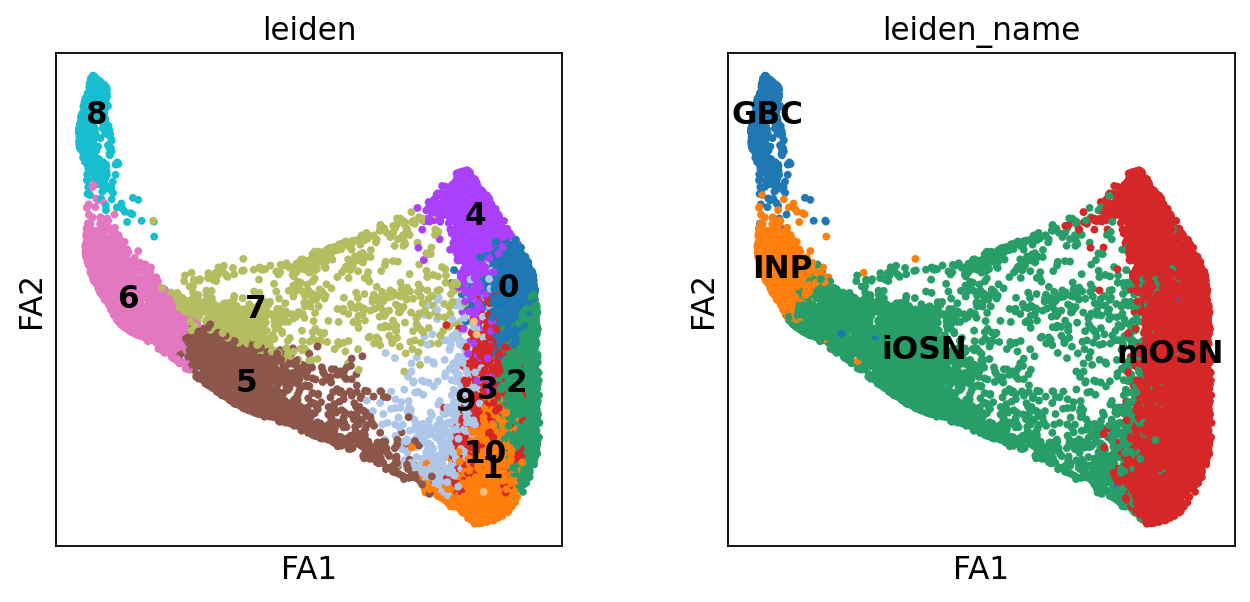

In [14]:
sc.set_figure_params(facecolor='white')
sc.pl.draw_graph(adata, color=['leiden','leiden_name'], legend_loc='on data', size=50)

In [15]:
adata.uns['iroot'] = np.flatnonzero(adata.obs['leiden']  == '8')[0]
sc.tl.dpt(adata)
adata_processed.uns['iroot'] = np.flatnonzero(adata_processed.obs['leiden']  == '8')[0]
sc.tl.dpt(adata_processed)

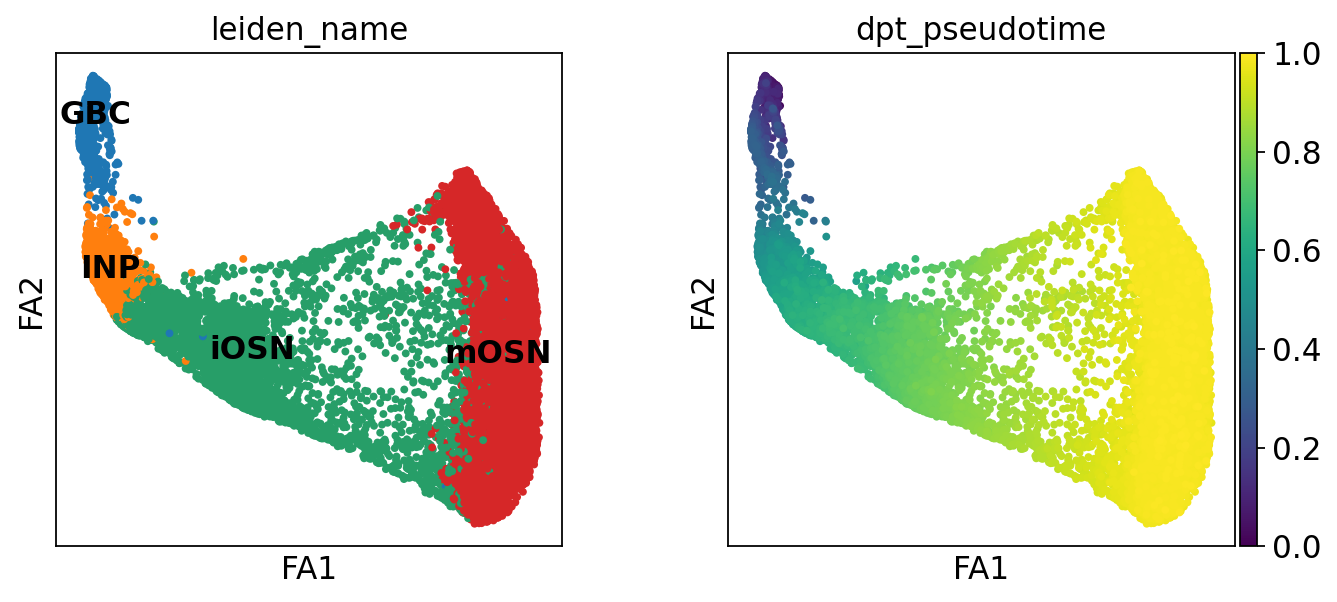

In [16]:
sc.pl.draw_graph(adata, color=['leiden_name', 'dpt_pseudotime'], legend_loc='on data', size=50)

/data/jlu/anaconda3/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'selected_dpt' as categorical


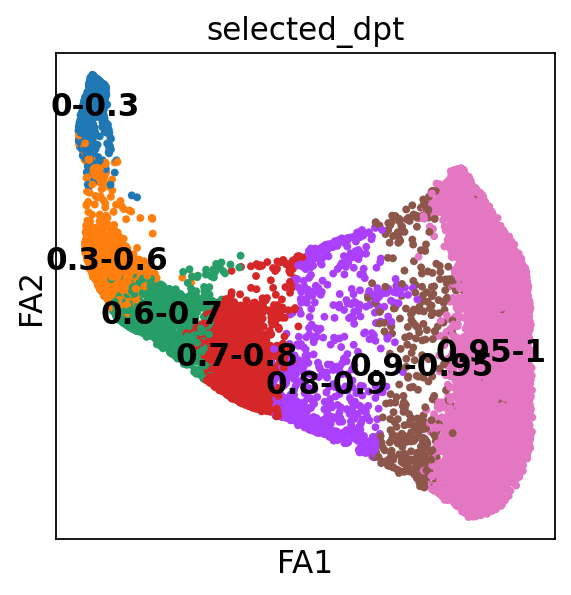

In [17]:
adata = GE_functions.add_selected_dpt(adata, dpt_cutoff=[0,0.3,0.6,0.7,0.8,0.9,0.95,1])
adata_processed = GE_functions.add_selected_dpt(adata_processed, dpt_cutoff=[0,0.3,0.6,0.7,0.8,0.9,0.95,1])
sc.pl.draw_graph(adata, color=['selected_dpt'], legend_loc='on data', size=50)

In [242]:
# Saving normalized adata. Raw contains untouched raw counts. 
# adata.write('./files/GSE151346_MOE_ALL_normalized.h5ad') 

In [18]:
gene_names = GE_functions.get_gene_names(adata)
excluded_genes = GE_functions.get_excluded_genes(gene_names)

In [ ]:
# construct ge_table
ge_normalized = GE_functions.get_ge_table(adata, gene_names, ge_across='selected_dpt')
ge_processed = GE_functions.get_ge_table(adata_processed, gene_names, ge_across='selected_dpt')
# convert average gene expression to relative gene expression. (Optional )
ge_normalized = GE_functions.gene_to_relative_expression(ge_normalized)
ge_processed = GE_functions.gene_to_relative_expression(ge_processed)
# Construct mse_table from the ge_table values relative to Rtp1(Default)
mse_normalized_rtp1 = GE_functions.get_mse_table(ge_normalized, gene_names)
mse_processed_rtp1 = GE_functions.get_mse_table(ge_processed, gene_names)

In [ ]:
# plotting processed 
fig = GE_functions.expression_line_plot(ge_processed, 
                                        GE_functions.filter_mse_table(mse_processed_rtp1, excluded_genes))
fig = fig.update_layout(title = 'Relative gene expression change across processed counts selected_dpt relative Rtp1 \n Data from Brann GBC/INP/iOSN/mOSN')
# fig.write_html("./output/brann/ge_line_selected_dpt_ALL_Rtp1_processed_normExp.html")
fig.show()

In [91]:
# combining normalized and processed mse_table and save 
mse_combined = mse_normalized_rtp1.transpose().rename(columns = {'mse': 'mse_normalized_normExp_ALL_rtp1'}).join(
    mse_processed_rtp1.transpose().rename(columns = {'mse': 'mse_processed_normExp_ALL_rtp1'}))
# mse_combined.to_csv('./output/brann/mse_combined_ALL_rtp1.csv')
mse_combined.to_csv('./output/brann/mse_combined_normExp_ALL_rtp1.csv')

In [71]:
# calculate mse_table relative to rtp2
mse_normalized_rtp2 = GE_functions.get_mse_table(ge_normalized, gene_names, mse_gene='Rtp2')
mse_processed_rtp2 = GE_functions.get_mse_table(ge_processed, gene_names, mse_gene='Rtp2')
# combining normalized and processed mse_table and save 
mse_combined = mse_normalized_rtp2.transpose().rename(columns = {'mse': 'mse_normalized_normExp_ALL_rtp2'}).join(
    mse_processed_rtp2.transpose().rename(columns = {'mse': 'mse_processed_normExp_ALL_rtp2'}))
# mse_combined.to_csv('./output/brann/mse_combined_ALL_rtp2.csv')
mse_combined.to_csv('./output/brann/mse_combined_normExp_ALL_rtp2.csv')

mse_table constructed
mse_table constructed


In [ ]:
# plotting normalized
fig = GE_functions.expression_line_plot(ge_normalized, 
                                        GE_functions.filter_mse_table(mse_normalized_rtp2, excluded_genes))
fig = fig.update_layout(title = 'Relative gene expression change across normalized selected_dpt relative Rtp2 \n Data from Brann GBC/INP/iOSN/mOSN')
# fig.write_html("./output/brann/ge_line_selected_dpt_ALL_Rtp2_normalized_normExp.html")
fig.show()

In [ ]:
# plotting normalized
fig = GE_functions.expression_line_plot(ge_normalized, 
                                        GE_functions.filter_mse_table(mse_processed_rtp2, excluded_genes))
fig = fig.update_layout(title = 'Average gene expression change across processed selected_dpt relative Rtp2 \n Data from Brann GBC/INP/iOSN/mOSN')
# fig.write_html("./output/brann/ge_line_selected_dpt_ALL_Rtp2_processed_normExp.html")
fig.show()

In [13]:
mse_combined = pd.read_csv('./output/brann/mse_combined_normExp_ALL_rtp1.csv', index_col=[0])

In [19]:
gene_names = list(mse_combined.index)
excluded_genes = GE_functions.get_excluded_genes(gene_names)

In [212]:
reload(GE_functions)

<module 'GE_functions' from '/data/jlu/scSeq_tsukahara/GE_functions.py'>

In [22]:
fig = GE_functions.x_y_scatter(mse_combined, 
            title = "normalized vs processed relExp counts relative to Rtp1 (GBC/INP/iOSN/mOSN)",
                              label_genes=excluded_genes
                              )
fig.show()
# fig.write_html("./output/brann/Scatter_combined_normExp_ALL_rtp1.html")


Translate the mse_combined mse into numerical ranks. So that when plotted, it's a direct numerical comparison instead of the skewed mse values 


In [15]:
mse_combined = pd.read_csv('./output/brann/mse_combined_normExp_ALL_rtp1.csv', index_col=[0])
normalized_rtp1 = mse_combined[mse_combined.columns[0]]
processed_rtp1 = mse_combined[mse_combined.columns[1]]
# mse_combined = pd.read_csv('./output/brann/mse_combined_normExp_ALL_rtp2.csv', index_col=[0])
# normalized_rtp2 = mse_combined[mse_combined.columns[0]]
# processed_rtp2 = mse_combined[mse_combined.columns[1]]

In [30]:
rank_index = []
for i in range(1,len(mse_combined)+1):
    rank_index.append(i)

In [17]:
rank_normalized_rtp1 = pd.DataFrame(index = normalized_rtp1.sort_values().index)
rank_normalized_rtp1['mse_rank_normalized_normExp_rtp1'] = rank_index
rank_processed_rtp1 = pd.DataFrame(index = processed_rtp1.sort_values().index)
rank_processed_rtp1['mse_rank_processed_normExp_rtp1'] = rank_index
rank_combined = rank_normalized_rtp1.join(rank_processed_rtp1)

# rank_normalized_rtp2 = pd.DataFrame(index = normalized_rtp2.sort_values().index)
# rank_normalized_rtp2['mse_rank_normalized_rtp2'] = rank_index
# rank_processed_rtp2 = pd.DataFrame(index = processed_rtp2.sort_values().index)
# rank_processed_rtp2['mse_rank_processed_rtp2'] = rank_index
# rank_combined = rank_normalized_rtp2.join(rank_processed_rtp2)

# index_order = pd.read_csv('./output/brann/Rank_gene_combined_ALL_rtp1.csv', index_col=[0]).index
# rank_combined.reindex(index_order).to_csv('./output/brann/Rank_gene_combined_normExp_ALL_rtp1.csv')
# rank_combined.reindex(index_order).to_csv('./output/brann/Rank_gene_combined_normExp_ALL_rtp2.csv')



In [ ]:
fig = GE_functions.rank_plot(rank_combined, 
                             title = "normalized vs processed rank relative to Rtp1 (GBC/INP/iOSN/mOSN)",
                             excluded_genes=excluded_genes)
fig.show()
# fig.write_html("./output/brann/Scatter_rank_combined_normExp_ALL_rtp1.html")

In [ ]:
fig = GE_functions.rank_plot(rank_combined, 
                             title = "normalized vs processed rank relative to Rtp2 (GBC/INP/iOSN/mOSN)",
                             excluded_genes=excluded_genes)
fig.show()
# fig.write_html("./output/brann/Scatter_rank_combined_normExp_ALL_rtp2.html")

In [31]:
combined = pd.read_csv('./output/brann/mse_combined_ALL_rtp1.csv', index_col=[0])
combined_normExp = pd.read_csv('./output/brann/mse_combined_normExp_ALL_rtp1.csv', index_col=[0])

In [32]:
rank_normalized = pd.DataFrame(index = combined[combined.columns[0]].sort_values().index)
rank_normalized['mse_rank_normalized_rtp1'] = rank_index
rank_norm_normExp = pd.DataFrame(index = combined_normExp[combined_normExp.columns[0]].sort_values().index)
rank_norm_normExp['mse_rank_normalized_normExp_rtp1'] = rank_index
rank_combined = rank_normalized.join(rank_norm_normExp)
# rank_combined.to_csv('./output/brann/Rank_gene_combined_normExp_ALL_rtp2.csv')


In [34]:
fig = GE_functions.rank_plot(rank_combined, 
                             title = "normalized vs normalized_normExp rank relative to Rtp1 (GBC/INP/iOSN/mOSN)",
                             excluded_genes=excluded_genes)
fig.show()
# fig.write_html("./output/brann/Scatter_rank_normalized_normExp_ALL_rtp1.html")